In [0]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline
import os

Using TensorFlow backend.


# Convolutional Neural Networks for Image Classification

In brief, a neural network is an approximation to a function $\hat f(x; \theta) \approx f(x)$ that is parameterised by the coefficients $\theta$. The parameters, $\theta$, are optimised through a process called $\textit{backpropagation}$, in which the $\textit{error}$ in the approximation, $\hat f(x; \theta)$, is used to update the parameters, $\theta$. The error is obtained by first defining a $\textit{loss function}$, which specifies how to penalise the deviation of the neural network's outputs from the desired outputs. To create and train a neural network, you must first define:

1. The "function" , or neural network architecture
2. The loss function
3. The training algorithm - in general this is simply computing the model outputs, calculating the loss, and updating the model parameters according to the gradient with respect to the parameters

The Keras and Tensorflow frameworks make it straightforward to build and train a neural network, while allowing flexibility where needed.

In [0]:
def neural_network(input_shape=(32, 32, 3), layer_filters=(32, 64, 128), num_classes=10, hidden_activation='relu', output_activation='softmax', with_embedding=False):
  """
  Defines a generic feed forward neural network architecture with an arbitrary number of hidden layers
  and nodes.
  :param layer_nodes: Number of nodes in hidden layers and output layer.
    0th element specifies the input layer, last element specifies output layer
  :type layer_nodes: tuple
  :param hidden_activation: Name of hidden layer activation function or function
  :type hidden_activation: str or callable
  :param output_activation: Name of output activation function or function
  :type output_activation: str or callable
  :return: keras model object
  :rtype: keras.models.Model
  """
  model_input = keras.layers.Input(input_shape, name='model_input')
  x = model_input
  for i, num_filters in enumerate(layer_filters, start=1):
    x = keras.layers.Conv2D(num_filters,
                            kernel_size=(3, 3),
                            activation=hidden_activation,
                            name='hidden_layer_%d_1' % i,
                            padding='same')(x)
    x = keras.layers.Conv2D(num_filters,
                            kernel_size=(3, 3),
                            activation=hidden_activation,
                            name='hidden_layer_%d_2' % i,
                            padding='same')(x)
    x = keras.layers.MaxPooling2D((2, 2),
                                  strides=(2, 2),
                                  padding='same',
                                  name='maxpool_%d' % i)(x)
  x = keras.layers.Flatten(name='final_flattened')(x)
  x = keras.layers.Dropout(0.5)(x)
  model_output = keras.layers.Dense(num_classes, activation=output_activation, name='output_layer')(x)
  if with_embedding:
    embedding = x
    output = [model_output, embedding]
  else:
    output = model_output
  return keras.models.Model(model_input, output)  

In [0]:
def transfer_weights(model_source, model_destination):
  """
  Given two model objects with identical structure, transfers weights from one to the other
  :param model_source: Model to transfer weights from
  :type model_source: keras.models.Model
  :param model_destination: Model to transfer weights to
  :type model_destination: keras.models.Model
  :return: None
  :rtype: None
  """
  for source_layer, dest_layer in zip(model_source.layers, model_destination.layers):
    dest_layer.set_weights(source_layer.get_weights())

In [0]:
def imscatter(images, coords, ax=None, zoom=1, subset=1):
    """
    Plot a scatter plot of the images by placing each image at the given coordinate
    :param images: (list) of images to be plotted
    :param coords: (list) of coordinates of form (x, y)
    :param ax: (matplotlib Axes object)
    :param zoom:
    :param subset:
    :return:
    """
    if not isinstance(images, np.ndarray):
        images = np.array(images)[:, :, :, :3]
    if not isinstance(coords, np.ndarray):
        coords = np.array(coords)
    if subset != 1:
        N = len(images)
        keep_idx = np.random.permutation(np.arange(N))
        keep_idx = keep_idx[:int(round(N * subset))]
        images = images[keep_idx]
        coords = coords[keep_idx]
    if ax is None:
        ax = plt.gca()
    artists = []
    for image, coord in zip(images, coords):
        im = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(im, coord, xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(coords[:, :2])
    ax.autoscale()
    return artists

def generate_random_indices(num_range, num_idx):
  return np.random.permutation(np.arange(num_range))[:num_idx]

In [0]:
# print out summary of default network, specifies layer dimensions and number of parameters
neural_network().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     (None, 32, 32, 3)         0         
_________________________________________________________________
hidden_layer_1_1 (Conv2D)    (None, 32, 32, 32)        896       
_________________________________________________________________
hidden_layer_1_2 (Conv2D)    (None, 32, 32, 32)        9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
hidden_layer_2_1 (Conv2D)    (None, 16, 16, 64)        18496     
_________________________________________________________________
hidden_layer_2_2 (Conv2D)    (None, 16, 16, 64)        36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 8, 8, 64)          0         
__________

## CIFAR10 Data Set

"Dataset of 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images." (from keras documentation)
The data set contains image from the following classes:

1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

In [0]:
from keras.datasets import cifar10

In [0]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_dict = {i: name for i, name in enumerate(label_names)}

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 39s 0us/step


In [0]:
x_train.shape

(50000, 32, 32, 3)

### Visualising CIFAR10

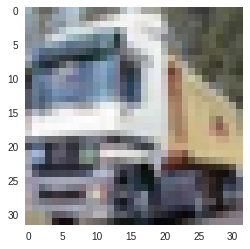

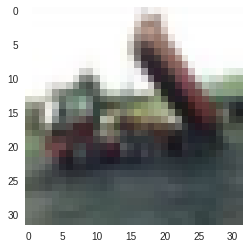

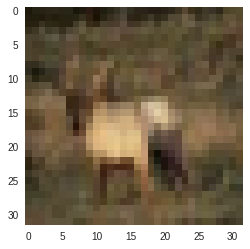

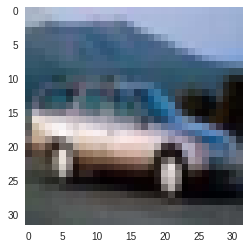

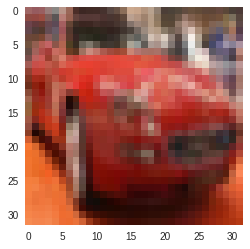

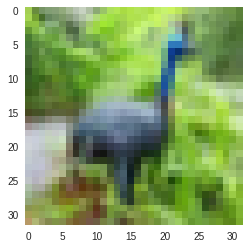

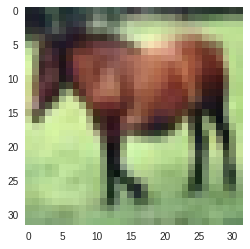

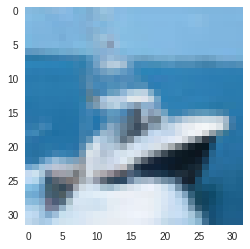

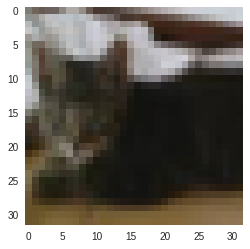

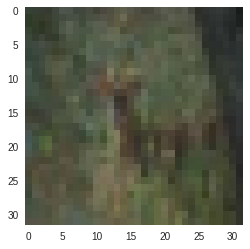

In [0]:
num_display = 10
rand_idx = np.random.permutation(np.arange(num_display))
for i, idx in enumerate(rand_idx, start=1):
#   plt.subplot(1, num_display, i)
  plt.figure()
  plt.imshow(x_train[i])
  plt.grid(False)
  plt.show()

### Training a convolutional neural network to classify CIFAR10 images
This involves the following steps:  
1. Normalise each image from range [0, 255] to range [-1, 1]. This is a basic form of normalisation that just gets the inputs in the same range as the network weights. Other forms of normalisation include $\textit{standard scaling}$, in which the mean of the training set is subtracted from each image and then each image is divided by the training set standard deviation. This zero-centers the data and ensures it has a variance of 1, giving it the same distribution as a the model weights.

2. Splitting the data set into training and testing partitions. Typically one will use a large fraction of the data (e.g, 2/3rds) for training

In [0]:
def normalise_array(x):
  """
  Normalises image to [-1, 1].
  :param x: Input array to be normalised
  :type x: numpy.ndarray
  :return: Normalised array
  :rtype: numpy.ndarray
  """
  return 2 * (x - x.min()) / (x.max() - x.min()) - 1

def preprocess_data(x):
  normalised_data = normalise_array(x)
  flattened_data = flatten_array(normalised_data)
  return flattened_data

In [0]:
normalised_x_train = normalise_array(x_train)
normalised_x_test = normalise_array(x_test)

In [0]:
classifier = neural_network()
# print out summary of network parameters and layer dimensions
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     (None, 32, 32, 3)         0         
_________________________________________________________________
hidden_layer_1_1 (Conv2D)    (None, 32, 32, 32)        896       
_________________________________________________________________
hidden_layer_1_2 (Conv2D)    (None, 32, 32, 32)        9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
hidden_layer_2_1 (Conv2D)    (None, 16, 16, 64)        18496     
_________________________________________________________________
hidden_layer_2_2 (Conv2D)    (None, 16, 16, 64)        36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 8, 8, 64)          0         
__________

Note that this network has a total of 98,378 parameters. For a small enough data set, this can be enough to entirely memorise the entire data set, in a process called overfitting. Consider than a single CIFAR10 image has $32 \times 32 \times 3 = 3072$ pixels.

### Network outputs
Each of the ten output nodes of the network predicts the value $P_k(y_i = c_k | x_i)$. That is, the $kth$ output neuron predicts the probability of the $ith$ data belonging to the $kth$ class, $c_k$. Because we're using the softmax activation function, the output probabilities represent the mutually exclusive class membership probabilities, and the outputs per data sample sum to 1.

* We run the network without any training to obtain the class probabilities below and plot a histogram
* We also calculate the accuracy of each prediction

In [0]:
predictions = classifier.predict(normalised_x_train)

#### Histogram of predicted class-membership probability without any training
Note that the probabilities are all quite low and roughly normally distributed somewhere close to 0.10. This is what we expect for a randomly initialised model, which generally predicts each class with equal probability. In the case of 10 classes, that probability is 0.10.

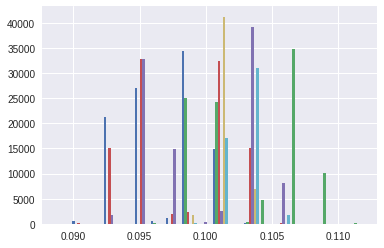

In [14]:
_, _, _ = plt.hist(predictions)

### Neural network embeddings
Another useful way of visualising neural network outputs is by looking at the $\textit{feature embeddings}$ of the inputs. Embeddings are projections of raw inputs (in this case, images) onto a lower dimensional vector space. A well-trained network embeds its inputs in a set of distinct clusters, with each cluster consisting mostly (entirely, for a perfect classifier) of members of the same class.

Typically, the embedding space is too high dimensional to visualise directly. To get around this we apply dimensionality reduction techniques such as t-stochastic nearest neighbor embedding (t-SNE) and principal component analysis (PCA) to reduce the number of dimensions to either 2 or 3. TSNE embeds the inputs such that samples that are close together in the original embedding space remain close together in the reduced space. PCA does not preserve neighborhood structure, but the advantage of being more computationally efficient. With PCA, the axes of the embedding space represent the directions in the original space along with the data varied the most, with the first PCA component accounting for most of the variance. We demonstrate both approaches below.

In [0]:
# create version of model that returns embeddings of layer before output layer
embedding_classifier = neural_network(with_embedding=True)

In [0]:
# transfer weights from initial classifier to embedding classifier
transfer_weights(classifier, embedding_classifier)

In [0]:
# probabilities and embeddings from embedding classifier
embedding_classifier_predictions, embeddings = embedding_classifier.predict(normalised_x_train)

In [18]:
# Note that the dimensionality of the embedding space is 512
embeddings.shape

(50000, 2048)

In [0]:
# verify that the two models produce the same outputs
np.allclose(predictions, embedding_classifier_predictions)

True

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#### PCA
We reduce the 512-dimensional embeddings to 2-D space for easy visualisation.

In [20]:
pca = PCA(n_components=2)
pca_space_embeddings = pca.fit_transform(embeddings)
pca_space_embeddings.shape

(50000, 2)

In [0]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

In [0]:
num_plot = 1000
rand_selection = generate_random_indices(pca_space_embeddings.shape[0], num_plot)

##### Plot of class distribution in 2D space using PCA
Note that the distribution of the classes if fairly random.

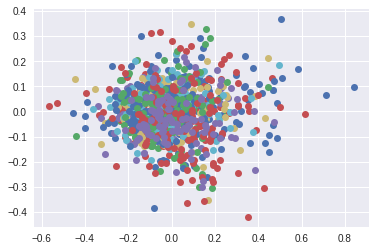

In [23]:
for cl in range(10):
  mask = np.squeeze(y_train[rand_selection] == cl)
  plt.plot(pca_space_embeddings[rand_selection, 0][mask], pca_space_embeddings[rand_selection, 1][mask], colors[cl] + 'o')

#### t-SNE 

In [0]:
tsne = TSNE(n_components=2)
rand_selection = generate_random_indices(embeddings.shape[0], 1000)

In [25]:
tsne_space_embeddings = tsne.fit_transform(embeddings[rand_selection])
tsne_space_embeddings.shape

(1000, 2)

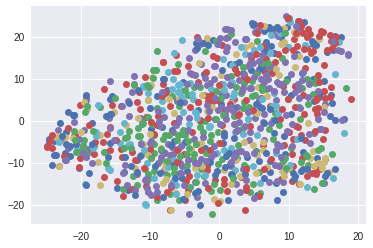

In [0]:
for cl in range(10):
  mask = np.squeeze(y_train[rand_selection] == cl)
  plt.plot(tsne_space_embeddings[:, 0][mask], tsne_space_embeddings[:, 1][mask], colors[cl] + 'o')

### Training the network
Here we train the network and observe the outputs in the same manner as above.
Note that we have not done any preprocessing of the training targets. However, they do need to be 'one-hot' encoded before being supplied to the network. Observe the raw targets below:


In [0]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

Each target is simply an integer ranging from 0 to 9, according to the class of the corresponding image. To one-hot encode an integer k, we simply produce the vector (0, ..., 1,... 0), where the vector is 1 at the kth position. Thus, the one-hot encoding of the integer 3 for a 10-class problem is the vector (0, 0, 0, 1, 0, 0, 0, 0, 0, 0).

In [0]:
def to_one_hot(integer_list, num_classes=10):
  integer_list = np.squeeze(integer_list)  # remove extra dimensions
  N = len(integer_list)
  y = np.zeros((N, num_classes))
  y[np.arange(N), integer_list] = 1  # some numpy-foo
  return y

In [27]:
one_hot_y_train = to_one_hot(y_train)
one_hot_y_test = to_one_hot(y_test)
one_hot_y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [0]:
classifier.compile(keras.optimizers.Adam(5e-4), loss=keras.losses.categorical_crossentropy, metrics=[keras.metrics.categorical_accuracy])

In [29]:
history = classifier.fit(normalised_x_train, one_hot_y_train, epochs=100, batch_size=512, validation_data=(normalised_x_test, one_hot_y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 13s 251us/step - loss: 2.1248 - categorical_accuracy: 0.2042 - val_loss: 1.8232 - val_categorical_accuracy: 0.3428
Epoch 2/100
50000/50000 [==============================] - 10s 209us/step - loss: 1.7510 - categorical_accuracy: 0.3611 - val_loss: 1.6236 - val_categorical_accuracy: 0.4133
Epoch 3/100
50000/50000 [==============================] - 10s 208us/step - loss: 1.6387 - categorical_accuracy: 0.4037 - val_loss: 1.6860 - val_categorical_accuracy: 0.3922
Epoch 4/100
50000/50000 [==============================] - 10s 208us/step - loss: 1.5333 - categorical_accuracy: 0.4436 - val_loss: 1.4753 - val_categorical_accuracy: 0.4713
Epoch 5/100
50000/50000 [==============================] - 10s 208us/step - loss: 1.4529 - categorical_accuracy: 0.4727 - val_loss: 1.4052 - val_categorical_accuracy: 0.4957
Epoch 6/100
50000/50000 [==============================] - 10s 208us/step - loss

KeyboardInterrupt: ignored

### Outputs of a trained classifier
We previously saw that the outputs of a trained classifier were more or less normally distributed about 0.10. For a trained classifier, we should expect to see a bimodal distribution, with probabilities clustered close to 0 and 1. This is because a confident classifier is likely to predict high probabilities for the correct class and predict low probabilities for everything else. Plotting the histogram below, this is exactly what we see.

In [0]:
train_predictions = classifier.predict(normalised_x_train)
test_predictions = classifier.predict(normalised_x_test)

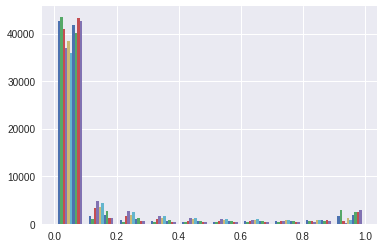

In [31]:
_, _, _ = plt.hist(train_predictions)

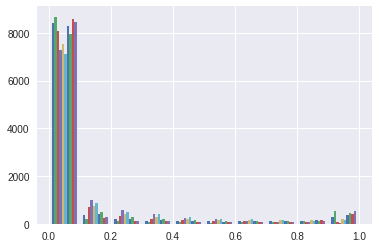

In [32]:
_, _, _ = plt.hist(test_predictions)

We visualise the images and their corresponding ground truth and predicted classes below

In [0]:
num_display = 10

def show_predictions(predictions, ground_truth, images, num_display, label_dict):
  rand_idx = generate_random_indices(predictions.shape[0], num_display)
  predicted_classes = np.argmax(predictions, axis=-1)  # take index of maximum probability for each row
  for i, idx in enumerate(rand_idx, start=1):
    plt.figure()
    title_string = "True Class: " + label_dict[ground_truth[i]] + " Predicted class: " + label_dict[predicted_classes[i]]
    plt.title(title_string)
    plt.imshow(images[i])
    plt.grid(False)
    plt.show()

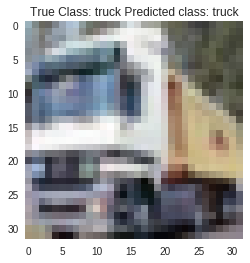

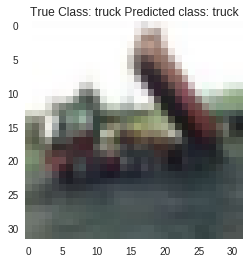

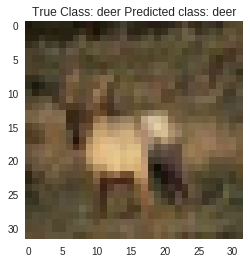

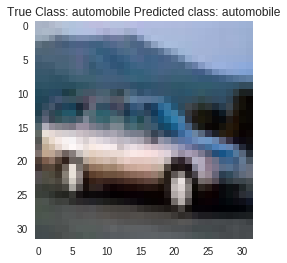

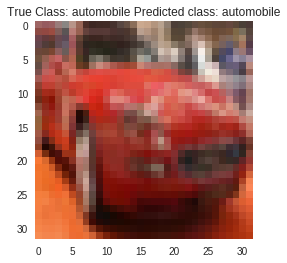

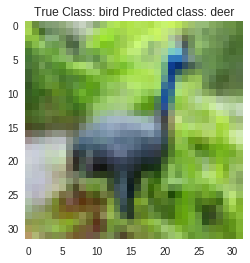

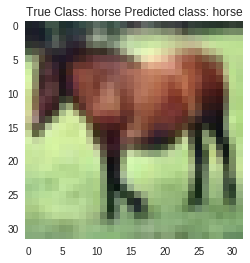

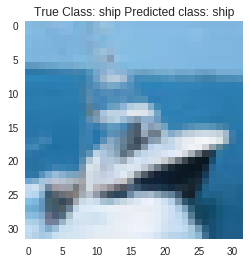

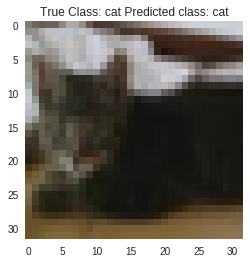

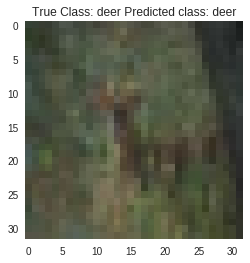

In [34]:
show_predictions(train_predictions, np.squeeze(y_train), x_train, num_display, label_dict)

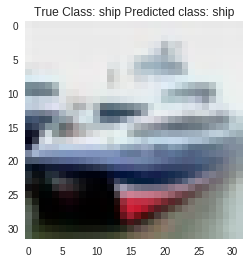

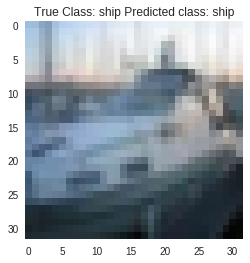

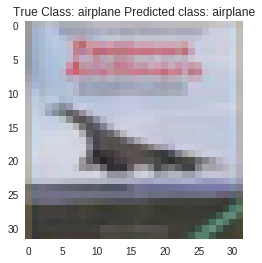

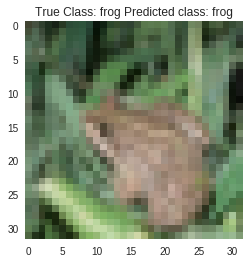

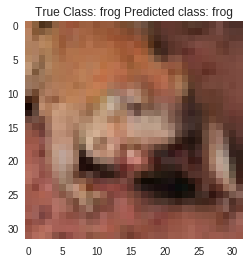

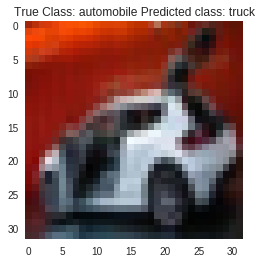

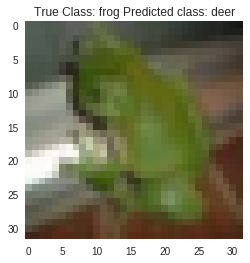

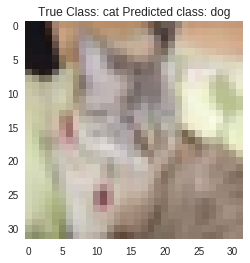

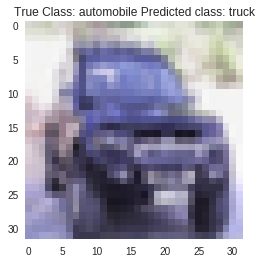

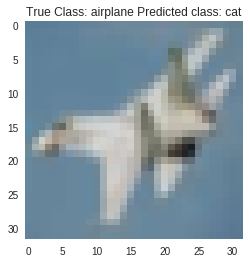

In [35]:
show_predictions(test_predictions, np.squeeze(y_test), x_test, num_display, label_dict)

#### Embeddings of a trained classifier
Now we look at the embeddings of a trained classifier. We expect more distinct clustering this time, though not perfect clustering unless the model was trained to near-100% accuracy.

In [0]:
embedder_classifier = neural_network(with_embedding=True)
transfer_weights(classifier, embedder_classifier)

In [0]:
emb_predictions, embeddings = embedder_classifier.predict(normalised_x_train)

In [0]:
tsne = TSNE(2)
rand_selection = generate_random_indices(embeddings.shape[0], 1000)
tsne_embeddings = tsne.fit_transform(embeddings[rand_selection])

We plot the embeddings for all classes below. Given the density of points, it's quite difficult to separate out individual clusters, although the clustering is fairly apparent.

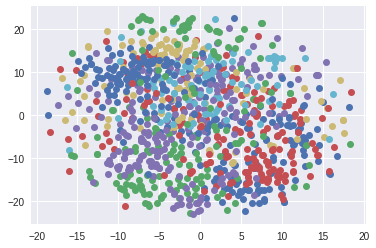

In [40]:
for cl in range(10):
  mask = np.squeeze(y_train[rand_selection] == cl)
  plt.plot(tsne_embeddings[:, 0][mask], tsne_embeddings[:, 1][mask], colors[cl] + 'o')

We plot fewer classes below to better demonstrate the separability in the embeddings.

Note that 'frog' and 'truck' images are quite separately embedded by the neural network.

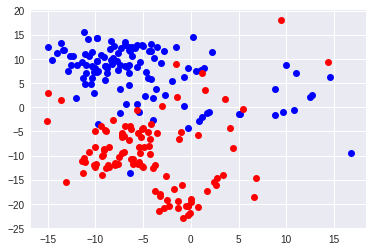

In [41]:
classes = ['frog', 'truck']
clrs = ['b', 'r']
for i, cl in enumerate([label_names.index(name) for name in classes]):
  mask = np.squeeze(y_train[rand_selection] == cl)
  plt.plot(tsne_embeddings[:, 0][mask], tsne_embeddings[:, 1][mask], clrs[i] + 'o')

We plot the 'ship' and 'airplane' categories below. Note that there is significantly more overlap in the embeddings of these categories. One can hypothesise that this is due to the similarities between 'ship' and 'airplane' images, with both having similar geometry and background - especially in coarse 32x32 images.

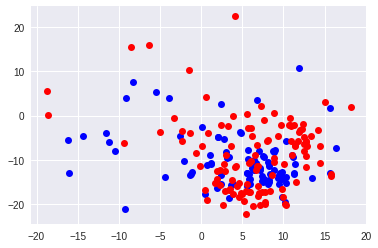

In [42]:
classes = ['ship', 'airplane']
clrs = ['b', 'r']
for i, cl in enumerate([label_names.index(name) for name in classes]):
  mask = np.squeeze(y_train[rand_selection] == cl)
  plt.plot(tsne_embeddings[:, 0][mask], tsne_embeddings[:, 1][mask], clrs[i] + 'o')

### Visual semantic nearest neighbor search with neural network embeddings
Embeddings are useful because they allow us to work with complex inputs such as images as if they were ordinary vector data. Here, we show how embeddings can allow us to find the most similar image, given a query image. That is, given a query image $I_q$, find the image $I_m$ that is most visually similar to it. The process is as follows:

1. Construct a kd-tree* using the image embeddings as data points.

2. Query the kd-tree for the closest point to the image embedding

A kd-tree computes distance using the Euclidean norm. This carries with it the requirement that our images must be embedded in a Euclidean manifold so that they can sensibly be compared.

\* A kd-tree is a data structure that enables efficient nearest neighbor lookups. Naive nearest neighbor lookups have a worst case runtime of $O(n^2)$, whereas kd-trees have a worst case of $O(n)$. This difference would quickly become noticeable on a reasonably sized database.

In [0]:
from scipy.spatial import KDTree

In [0]:
tree = KDTree(tsne_embeddings)

In [0]:
# remember we only embedded a random subset of all data points
selected_images = x_train[rand_selection]

In [0]:
def query_random_nearest(images, tree, num_neighbors=1):
  """
  Generate a random query image and plot its `num_neighbors` nearest neighbors
  :param images: Images that have been embedded
  :type images: numpy.ndarray
  :param tree: KD Tree storing image embeddings
  :type tree: scipy.spatial.KDTree
  :return: None
  :rtype: None
  """
  num_neighbors = min(num_neighbors, 3)  # max 3 neighbors, for ease of display
  n = len(tree.data)
  image_idx = np.random.randint(low=0, high=n)
  query_image = images[image_idx]
  distances, indexes = tree.query(tree.data[image_idx], k=num_neighbors+1)  # add one since the closest neighbor is the point itself
  indexes = indexes[1:]
  neighboring_images = images[indexes]
  num_subplot_rows = 4
  plt.figure(figsize=(20, 20))
  plt.subplot(num_subplot_rows, 2, 1)
  plt.grid(False)
  plt.imshow(query_image)
  for i in range(len(neighboring_images)):
    plt.subplot(num_subplot_rows, 2, i+2)
    plt.imshow(neighboring_images[i])
    plt.grid(False)

Each time the cell below is run, a random query image will be selected and its $k$ nearest neighbors will be found and plotted along side it. The query image is plotted on the top left.

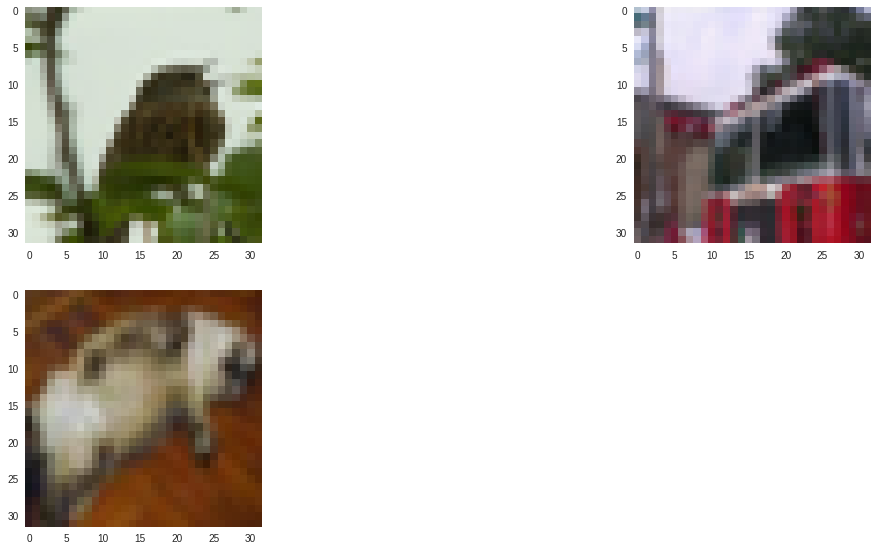

In [55]:
query_random_nearest(selected_images, tree, num_neighbors=2)